In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Common packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from scipy.stats import uniform, randint

# Sklearn for ML
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

# Custom packages
os.chdir("C:/Users/Titouan/Documents/HepavirAlgo")
pd.set_option("display.max_columns", None)
import funcsnds.predstatus as ps
import funcsnds.globalvar as gv

In [3]:
path_snds = "D:/Data/HEPAT_VUE_30012023/HEP_CSV/"
snds_hepather = pd.read_csv("data/chainage_snds_statut_hepather.csv").drop_duplicates()

# Création du dataset

In [4]:
cat_target = "chronique_C"

affine_used = {
    "DCIR" : ["ER_BIO_F", "ER_CAM_F", "ER_PHA_F", "ER_UCD_F"],
    "MCO"  : ["A", "D", "UM", "FL", "FM"],
    "SSR"  : ["D", "FL"]
}

curated_vars = None
# Si on voulait choisir les variables à la main
#curated_vars = gv.chronique_c_curated
how_many_vars = 10

In [5]:
# # Creation du dataset, à réaliser une fois, sauf si on change les variables
# range_year = range(12,22)
# _ = ps.create_snds_allyear_allnumenq(range_year, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

In [6]:
# Moyennisation des données sur 3 ans
type_agreg = "mean"
df_final, var_predict = ps.create_dateset_threeyears(type_agreg, snds_hepather, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

# Si on voulait garder une seule année
#df_final, var_predict = ps.create_dateset_oneyear(snds_hepather, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

In [8]:
# Permet de se rendre compte si des variables sont "largement distribuées" ce qui pourrait ralentir le processus sur le portail CNAM
for column_name in df_final.columns:
    column = df_final[column_name]
    perc = np.round(100*(column == 0).sum()/len(column),1)
    print("Perc in", column_name, " is : ", perc)

Perc in NUM_ENQ  is :  0.0
Perc in BIO_PRS_IDE/1000  is :  87.0
Perc in BIO_PRS_IDE/1104  is :  8.7
Perc in BIO_PRS_IDE/1208  is :  48.4
Perc in BIO_PRS_IDE/1740  is :  96.4
Perc in BIO_PRS_IDE/1806  is :  52.1
Perc in BIO_PRS_IDE/2004  is :  80.5
Perc in BIO_PRS_IDE/320  is :  48.1
Perc in BIO_PRS_IDE/322  is :  67.2
Perc in BIO_PRS_IDE/323  is :  72.7
Perc in BIO_PRS_IDE/351  is :  76.3
Perc in BIO_PRS_IDE/353  is :  90.4
Perc in BIO_PRS_IDE/354  is :  91.0
Perc in BIO_PRS_IDE/4120  is :  75.5
Perc in BIO_PRS_IDE/4124  is :  52.2
Perc in BIO_PRS_IDE/4125  is :  88.5
Perc in BIO_PRS_IDE/4500  is :  100.0
Perc in BIO_PRS_IDE/4711  is :  99.8
Perc in BIO_PRS_IDE/519  is :  13.5
Perc in BIO_PRS_IDE/522  is :  8.8
Perc in BIO_PRS_IDE/563  is :  71.1
Perc in CAM_PRS_IDE/BGQP002  is :  83.2
Perc in CAM_PRS_IDE/BZQK001  is :  91.3
Perc in CAM_PRS_IDE/DEQP003  is :  77.5
Perc in CAM_PRS_IDE/DZQM006  is :  79.8
Perc in CAM_PRS_IDE/EPPP003  is :  100.0
Perc in CAM_PRS_IDE/HBGD036  is :  91.7
Pe

In [9]:
# # En utilisant le split de sklearn
# X_train, X_test, y_train, y_test = train_test_split(df_final[var_predict], df_final[cat_target], test_size = 0.3)
# dtrain = xgb.DMatrix(X_train, label = y_train)
# dtest = xgb.DMatrix(X_test, label = y_test)

# Custom function pour resampler et "balanced" dans l'échantillon d'entraînement
# Le seed n'est pas figé à dessein, pour ne pas "overfitter le seed"
#X_cv, y_cv, X_test, y_test, num_enq_train = ps.prepare_data(cat_target, var_predict, df_final, size_train = 0.8)

X_cv, X_test, y_cv, y_test = train_test_split(df_final[var_predict], df_final[cat_target], test_size = 0.2)
num_enq_train = list(df_final.iloc[X_cv.index]["NUM_ENQ"])
num_enq_test = list(df_final.iloc[X_test.index]["NUM_ENQ"])
spw = (len(y_cv) - y_cv.sum())/y_cv.sum()
print(f"Le déséquilibre dans l'échantillon d'entraînement est de {np.round(spw, 1)} fois plus de négatifs que positifs")

Le déséquilibre dans l'échantillon d'entraînement est de 0.6 fois plus de négatifs que positifs


# Entraînement régression Logisitique

En raison de problèmes d'importation des modèles XGBoost au format `.json` sur la plateforme CNAM, un modèle linéaire a été estimé

In [12]:
%%time

## Random search XGB

model_simple = LogisticRegression(class_weight=spw, max_iter = 2000, fit_intercept = False)

param_distrib_log = {
    "C" : uniform(0.1, 2)
}

clf_log = RandomizedSearchCV(
    model_simple, 
    param_distributions = param_distrib_log,
    scoring = "balanced_accuracy", 
    n_iter = 50, cv = 4, 
    n_jobs = 1,
    verbose = 10,
    return_train_score = True
)

clf_log.fit(X_cv, y_cv)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START C=0.6220384460644642.......................................
[CV 1/4; 1/50] END C=0.6220384460644642;, score=(train=0.868, test=0.852) total time=   0.6s
[CV 2/4; 1/50] START C=0.6220384460644642.......................................
[CV 2/4; 1/50] END C=0.6220384460644642;, score=(train=0.865, test=0.866) total time=   0.7s
[CV 3/4; 1/50] START C=0.6220384460644642.......................................
[CV 3/4; 1/50] END C=0.6220384460644642;, score=(train=0.868, test=0.863) total time=   0.7s
[CV 4/4; 1/50] START C=0.6220384460644642.......................................
[CV 4/4; 1/50] END C=0.6220384460644642;, score=(train=0.869, test=0.859) total time=   0.5s
[CV 1/4; 2/50] START C=0.8103095286745959.......................................
[CV 1/4; 2/50] END C=0.8103095286745959;, score=(train=0.868, test=0.853) total time=   0.6s
[CV 2/4; 2/50] START C=0.8103095286745959...........................

[CV 4/4; 12/50] END C=0.40053190082981416;, score=(train=0.868, test=0.859) total time=   0.5s
[CV 1/4; 13/50] START C=1.2128667098862727......................................
[CV 1/4; 13/50] END C=1.2128667098862727;, score=(train=0.869, test=0.854) total time=   0.8s
[CV 2/4; 13/50] START C=1.2128667098862727......................................
[CV 2/4; 13/50] END C=1.2128667098862727;, score=(train=0.865, test=0.866) total time=   0.8s
[CV 3/4; 13/50] START C=1.2128667098862727......................................
[CV 3/4; 13/50] END C=1.2128667098862727;, score=(train=0.868, test=0.862) total time=   0.9s
[CV 4/4; 13/50] START C=1.2128667098862727......................................
[CV 4/4; 13/50] END C=1.2128667098862727;, score=(train=0.869, test=0.859) total time=   0.8s
[CV 1/4; 14/50] START C=0.9531069641536166......................................
[CV 1/4; 14/50] END C=0.9531069641536166;, score=(train=0.869, test=0.853) total time=   0.7s
[CV 2/4; 14/50] START C=0.9531

[CV 3/4; 24/50] END C=0.591464987617874;, score=(train=0.868, test=0.863) total time=   0.6s
[CV 4/4; 24/50] START C=0.591464987617874.......................................
[CV 4/4; 24/50] END C=0.591464987617874;, score=(train=0.868, test=0.859) total time=   0.5s
[CV 1/4; 25/50] START C=0.982641060926161.......................................
[CV 1/4; 25/50] END C=0.982641060926161;, score=(train=0.869, test=0.853) total time=   0.7s
[CV 2/4; 25/50] START C=0.982641060926161.......................................
[CV 2/4; 25/50] END C=0.982641060926161;, score=(train=0.865, test=0.866) total time=   0.7s
[CV 3/4; 25/50] START C=0.982641060926161.......................................
[CV 3/4; 25/50] END C=0.982641060926161;, score=(train=0.868, test=0.862) total time=   0.8s
[CV 4/4; 25/50] START C=0.982641060926161.......................................
[CV 4/4; 25/50] END C=0.982641060926161;, score=(train=0.869, test=0.860) total time=   0.7s
[CV 1/4; 26/50] START C=1.72534300540

[CV 2/4; 36/50] END C=0.5932352119250165;, score=(train=0.865, test=0.866) total time=   0.6s
[CV 3/4; 36/50] START C=0.5932352119250165......................................
[CV 3/4; 36/50] END C=0.5932352119250165;, score=(train=0.868, test=0.863) total time=   0.6s
[CV 4/4; 36/50] START C=0.5932352119250165......................................
[CV 4/4; 36/50] END C=0.5932352119250165;, score=(train=0.868, test=0.859) total time=   0.5s
[CV 1/4; 37/50] START C=1.6972463143778251......................................
[CV 1/4; 37/50] END C=1.6972463143778251;, score=(train=0.869, test=0.853) total time=   0.9s
[CV 2/4; 37/50] START C=1.6972463143778251......................................
[CV 2/4; 37/50] END C=1.6972463143778251;, score=(train=0.866, test=0.865) total time=   0.9s
[CV 3/4; 37/50] START C=1.6972463143778251......................................
[CV 3/4; 37/50] END C=1.6972463143778251;, score=(train=0.868, test=0.861) total time=   1.0s
[CV 4/4; 37/50] START C=1.69724

[CV 1/4; 48/50] END C=0.9877348479569495;, score=(train=0.869, test=0.853) total time=   0.6s
[CV 2/4; 48/50] START C=0.9877348479569495......................................
[CV 2/4; 48/50] END C=0.9877348479569495;, score=(train=0.865, test=0.866) total time=   0.7s
[CV 3/4; 48/50] START C=0.9877348479569495......................................
[CV 3/4; 48/50] END C=0.9877348479569495;, score=(train=0.868, test=0.862) total time=   0.8s
[CV 4/4; 48/50] START C=0.9877348479569495......................................
[CV 4/4; 48/50] END C=0.9877348479569495;, score=(train=0.869, test=0.860) total time=   0.7s
[CV 1/4; 49/50] START C=1.417782695897518.......................................
[CV 1/4; 49/50] END C=1.417782695897518;, score=(train=0.869, test=0.853) total time=   0.8s
[CV 2/4; 49/50] START C=1.417782695897518.......................................
[CV 2/4; 49/50] END C=1.417782695897518;, score=(train=0.865, test=0.865) total time=   0.8s
[CV 3/4; 49/50] START C=1.4177826

RandomizedSearchCV(cv=4,
                   estimator=LogisticRegression(class_weight=0.6091470951792336,
                                                fit_intercept=False,
                                                max_iter=2000),
                   n_iter=50, n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017C8744C640>},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=10)

In [13]:
log_chosen = clf_log.best_estimator_

clf_log.best_params_

{'C': 0.24086499822657328}

In [14]:
predictions_score = clf_log.predict_proba(X_test)[:,1]

In [15]:
predictions = clf_log.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82      1256
         1.0       0.86      0.95      0.90      1999

    accuracy                           0.87      3255
   macro avg       0.88      0.85      0.86      3255
weighted avg       0.88      0.87      0.87      3255



In [16]:
clf_log.best_estimator_.intercept_

array([0.])

In [17]:
coef_model_log = pd.DataFrame([("CONSTANTE", + clf_log.best_estimator_.intercept_[0])] + list(zip(clf_log.feature_names_in_, clf_log.best_estimator_.coef_[0])), columns = ["Var", "Coef"])

In [41]:
if curated_vars == None :
    dump(clf_log, "results/" + cat_target + "/model_cv_log.joblib")
    coef_model_log.to_csv("results/" + cat_target + "/coef_model_log.csv", sep = ";", index = False)
else:
    dump(clf_log, "results/" + cat_target + "/model_cv_log_curated.joblib")
    coef_model_log.to_csv("results/" + cat_target + "/coef_model_log_curated.csv", sep = ";", index = False)

In [19]:
final = pd.DataFrame(list(zip(y_test, predictions, predictions_score)), columns = ["True", "Pred", "Score"])

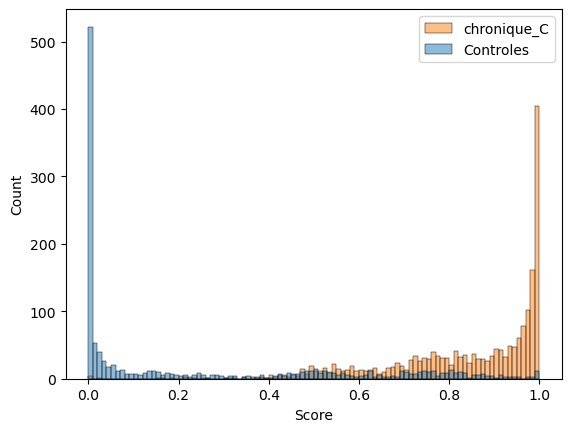

In [20]:
sns.histplot(data = final, x = "Score", hue = "True", bins = 100)
_ = plt.legend(labels = [cat_target, "Controles"])

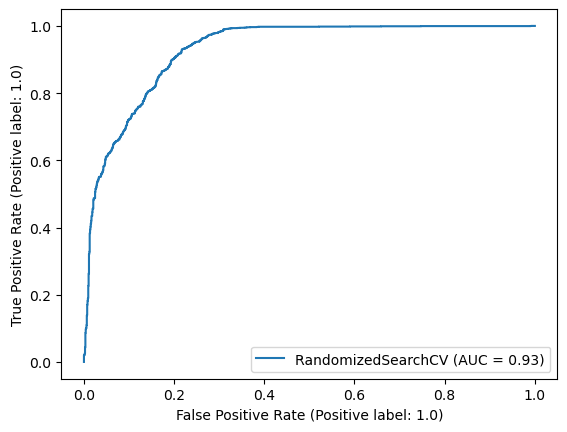

In [21]:
_ = RocCurveDisplay.from_estimator(clf_log, X_test, y_test)

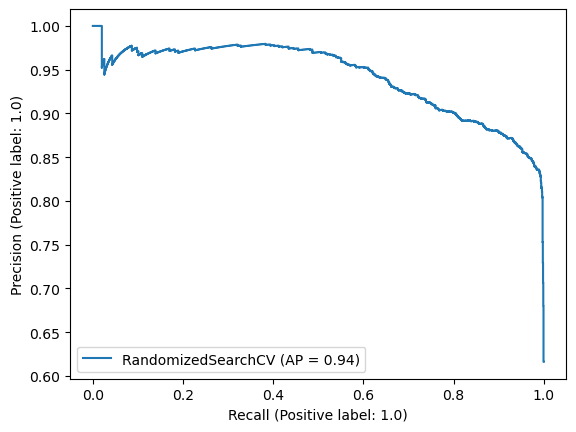

In [42]:
_ = PrecisionRecallDisplay.from_estimator(clf_log, X_test, y_test)

# Entraînement du XGBoost

In [23]:
## Recherche infructueuse avec plus de paramètres à parcourir

# %%time

# ## Random search XGB

# xgb_model = xgb.XGBClassifier()

# param_distrib_XGB = {
#     "n_estimators" : randint(50, 500),
#     "max_depth" : randint(2, 20),
#     "min_child_weight" : randint(1, 5),
#     "learning_rate" : uniform(0.01,1),
#     "gamma" : randint(0, 10)
# }

# clf = RandomizedSearchCV(
#     xgb_model, 
#     param_distributions = param_distrib_XGB,
#     scoring = "accuracy", 
#     n_iter = 200, cv = 4, 
#     n_jobs = 1,
#     verbose = 10
#     #random_state = 42
# )

# clf.fit(X_cv, y_cv)

In [24]:
%%time

## Random search XGB

xgb_model = xgb.XGBClassifier(scale_pos_weight = spw)

param_distrib_XGB = {
    "n_estimators" : randint(200, 300),
    "max_depth" : randint(1, 6),
}

clf = RandomizedSearchCV(
    xgb_model, 
    param_distributions = param_distrib_XGB,
    scoring = "balanced_accuracy", 
    n_iter = 50, cv = 4, 
    n_jobs = 1,
    verbose = 10,
    return_train_score = True
)

clf.fit(X_cv, y_cv)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START max_depth=1, n_estimators=225..............................
[CV 1/4; 1/50] END max_depth=1, n_estimators=225;, score=(train=0.879, test=0.861) total time=   0.8s
[CV 2/4; 1/50] START max_depth=1, n_estimators=225..............................
[CV 2/4; 1/50] END max_depth=1, n_estimators=225;, score=(train=0.874, test=0.869) total time=   0.6s
[CV 3/4; 1/50] START max_depth=1, n_estimators=225..............................
[CV 3/4; 1/50] END max_depth=1, n_estimators=225;, score=(train=0.873, test=0.871) total time=   0.6s
[CV 4/4; 1/50] START max_depth=1, n_estimators=225..............................
[CV 4/4; 1/50] END max_depth=1, n_estimators=225;, score=(train=0.874, test=0.870) total time=   0.6s
[CV 1/4; 2/50] START max_depth=2, n_estimators=259..............................
[CV 1/4; 2/50] END max_depth=2, n_estimators=259;, score=(train=0.904, test=0.862) total time=   0.9s
[CV 2/4; 2/50] START ma

[CV 1/4; 12/50] END max_depth=4, n_estimators=263;, score=(train=0.959, test=0.863) total time=   1.3s
[CV 2/4; 12/50] START max_depth=4, n_estimators=263.............................
[CV 2/4; 12/50] END max_depth=4, n_estimators=263;, score=(train=0.960, test=0.871) total time=   1.3s
[CV 3/4; 12/50] START max_depth=4, n_estimators=263.............................
[CV 3/4; 12/50] END max_depth=4, n_estimators=263;, score=(train=0.959, test=0.869) total time=   1.3s
[CV 4/4; 12/50] START max_depth=4, n_estimators=263.............................
[CV 4/4; 12/50] END max_depth=4, n_estimators=263;, score=(train=0.958, test=0.861) total time=   1.3s
[CV 1/4; 13/50] START max_depth=3, n_estimators=215.............................
[CV 1/4; 13/50] END max_depth=3, n_estimators=215;, score=(train=0.930, test=0.863) total time=   0.9s
[CV 2/4; 13/50] START max_depth=3, n_estimators=215.............................
[CV 2/4; 13/50] END max_depth=3, n_estimators=215;, score=(train=0.925, test=0.8

[CV 2/4; 23/50] END max_depth=4, n_estimators=284;, score=(train=0.962, test=0.868) total time=   1.5s
[CV 3/4; 23/50] START max_depth=4, n_estimators=284.............................
[CV 3/4; 23/50] END max_depth=4, n_estimators=284;, score=(train=0.961, test=0.870) total time=   1.5s
[CV 4/4; 23/50] START max_depth=4, n_estimators=284.............................
[CV 4/4; 23/50] END max_depth=4, n_estimators=284;, score=(train=0.963, test=0.860) total time=   1.5s
[CV 1/4; 24/50] START max_depth=5, n_estimators=213.............................
[CV 1/4; 24/50] END max_depth=5, n_estimators=213;, score=(train=0.973, test=0.862) total time=   1.3s
[CV 2/4; 24/50] START max_depth=5, n_estimators=213.............................
[CV 2/4; 24/50] END max_depth=5, n_estimators=213;, score=(train=0.968, test=0.864) total time=   1.3s
[CV 3/4; 24/50] START max_depth=5, n_estimators=213.............................
[CV 3/4; 24/50] END max_depth=5, n_estimators=213;, score=(train=0.969, test=0.8

[CV 3/4; 34/50] END max_depth=3, n_estimators=240;, score=(train=0.930, test=0.869) total time=   1.0s
[CV 4/4; 34/50] START max_depth=3, n_estimators=240.............................
[CV 4/4; 34/50] END max_depth=3, n_estimators=240;, score=(train=0.930, test=0.872) total time=   1.0s
[CV 1/4; 35/50] START max_depth=5, n_estimators=272.............................
[CV 1/4; 35/50] END max_depth=5, n_estimators=272;, score=(train=0.980, test=0.862) total time=   1.6s
[CV 2/4; 35/50] START max_depth=5, n_estimators=272.............................
[CV 2/4; 35/50] END max_depth=5, n_estimators=272;, score=(train=0.978, test=0.862) total time=   1.6s
[CV 3/4; 35/50] START max_depth=5, n_estimators=272.............................
[CV 3/4; 35/50] END max_depth=5, n_estimators=272;, score=(train=0.976, test=0.870) total time=   1.6s
[CV 4/4; 35/50] START max_depth=5, n_estimators=272.............................
[CV 4/4; 35/50] END max_depth=5, n_estimators=272;, score=(train=0.977, test=0.8

[CV 4/4; 45/50] END max_depth=4, n_estimators=252;, score=(train=0.957, test=0.860) total time=   1.3s
[CV 1/4; 46/50] START max_depth=2, n_estimators=272.............................
[CV 1/4; 46/50] END max_depth=2, n_estimators=272;, score=(train=0.905, test=0.863) total time=   1.0s
[CV 2/4; 46/50] START max_depth=2, n_estimators=272.............................
[CV 2/4; 46/50] END max_depth=2, n_estimators=272;, score=(train=0.904, test=0.873) total time=   1.0s
[CV 3/4; 46/50] START max_depth=2, n_estimators=272.............................
[CV 3/4; 46/50] END max_depth=2, n_estimators=272;, score=(train=0.905, test=0.872) total time=   1.0s
[CV 4/4; 46/50] START max_depth=2, n_estimators=272.............................
[CV 4/4; 46/50] END max_depth=2, n_estimators=272;, score=(train=0.904, test=0.869) total time=   1.0s
[CV 1/4; 47/50] START max_depth=4, n_estimators=282.............................
[CV 1/4; 47/50] END max_depth=4, n_estimators=282;, score=(train=0.962, test=0.8

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                            

In [25]:
xgb_chosen = clf.best_estimator_.get_booster()

clf.best_params_

{'max_depth': 2, 'n_estimators': 208}

In [26]:
# BEST_PARAMS = {'max_depth': 4, 'n_estimators': 213}

# clf = xgb.XGBClassifier(**BEST_PARAMS)

# clf.fit(X_cv, y_cv)

In [27]:
predictions_score = clf.predict_proba(X_test)[:,1]

In [29]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83      1256
         1.0       0.88      0.92      0.90      1999

    accuracy                           0.87      3255
   macro avg       0.87      0.86      0.87      3255
weighted avg       0.87      0.87      0.87      3255



In [30]:
predictions_cv = clf.predict(X_cv)
print(classification_report(y_cv, predictions_cv))

              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87      4928
         1.0       0.91      0.94      0.93      8090

    accuracy                           0.91     13018
   macro avg       0.91      0.90      0.90     13018
weighted avg       0.91      0.91      0.91     13018



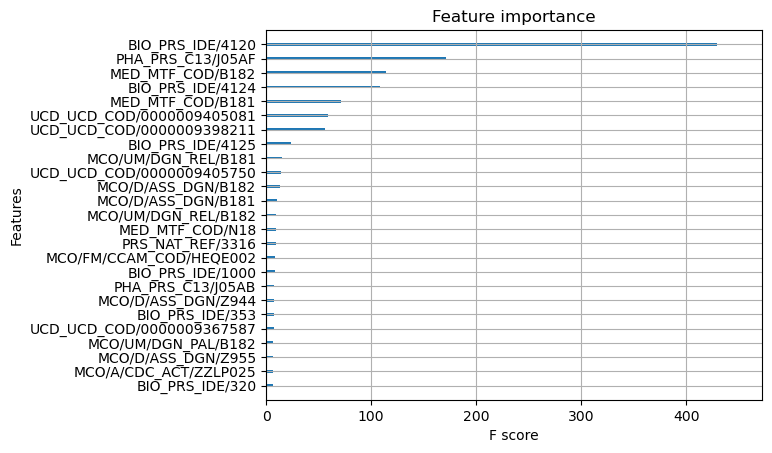

In [31]:
_ = xgb.plot_importance(clf.best_estimator_, 
                        importance_type = "gain",
                        max_num_features = 25,
                        show_values = False)

In [32]:
final = pd.DataFrame(list(zip(y_test, predictions, predictions_score)), columns = ["True", "Pred", "Score"])

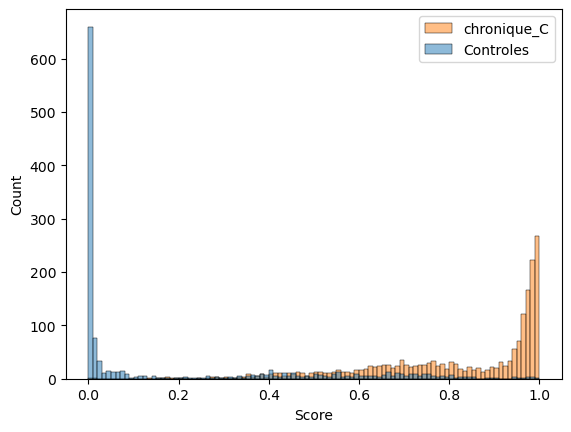

In [33]:
sns.histplot(data = final, x = "Score", hue = "True", bins = 100)
_ = plt.legend(labels = [cat_target, "Controles"])

In [34]:
if curated_vars == None :
    dump(clf, "results/" + cat_target + "/model_cv.joblib")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.json")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.txt")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.ubj")
else:
    dump(clf, "results/" + cat_target + "/model_cv_curated.joblib")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.json")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.txt")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.ubj")

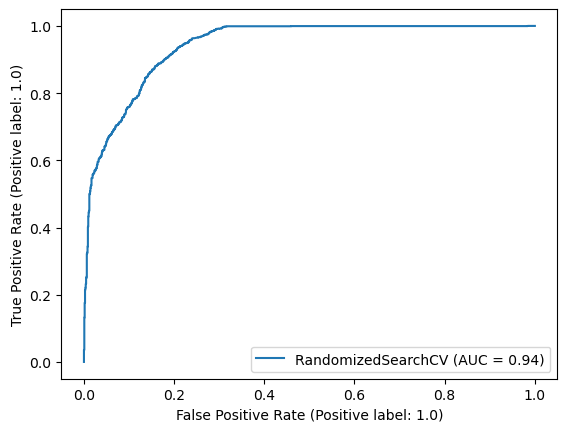

In [35]:
_ = RocCurveDisplay.from_estimator(clf, X_test, y_test)

# Si on faisait tourner l'algorithme sur plusieurs années

In [36]:
# Si au lieu de faire la moyenne sur 3 années on se limitait à une seule

# %%time
# save_score = []

# for myyear in range(12, 22):
#     print(myyear)
    
#     df_temp      = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear) + ".csv", sep = ";")
#     data_noleakage = df_temp[~df_temp["NUM_ENQ"].isin(num_enq_train)].copy()

#     X_pred, y_pred = data_noleakage[var_predict], data_noleakage[cat_target]
        
#     predictions_score = clf.predict_proba(X_pred)[:,1]
#     data_noleakage["results" + str(myyear)] = np.round(predictions_score, 2)
    
#     df_temp = data_noleakage[["NUM_ENQ", cat_target, "results" + str(myyear)]]
#     save_score.append(df_temp)
    
# df_total_score = ps.merge_years(save_score, cat_target)

In [37]:
%%time
save_score = []

for myyear in range(13, 21):
    print(myyear)
    
    df_temp_back = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear - 1) + ".csv", sep = ";")
    df_temp      = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear) + ".csv", sep = ";")
    df_temp_forw = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear + 1) + ".csv", sep = ";")
    
    df_temp = pd.concat([df_temp_back, df_temp, df_temp_forw])
    df_temp = df_temp[df_temp["NUM_ENQ"].isin(num_enq_test)]
    df_temp = df_temp.groupby("NUM_ENQ", as_index = False).mean()
    
    data_noleakage = df_temp
    
    X_pred, y_pred = data_noleakage[var_predict], data_noleakage[cat_target]
        
    predictions_score = clf.predict_proba(X_pred)[:,1]
    data_noleakage["results" + str(myyear)] = np.round(predictions_score, 2)
    
    df_temp = data_noleakage[["NUM_ENQ", cat_target, "results" + str(myyear)]]
    save_score.append(df_temp)
    
df_total_score = ps.merge_years(save_score, cat_target)

13
14
15
16
17
18
19
20
Wall time: 7.63 s


In [38]:
df_total_score = pd.merge(left = df_total_score, right = snds_hepather[["NUM_ENQ", "year_incl"]], on = "NUM_ENQ")

In [40]:
if curated_vars == None :
    df_total_score.to_csv("results/" + cat_target + "/df_score_year.csv", sep = ";", index = False)
else:
    df_total_score.to_csv("results/" + cat_target + "/df_score_year_curated.csv", sep = ";", index = False)